In [19]:
import cv2
import numpy as np
import pygame
import cairosvg
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import os
import heapq

In [20]:
# Set the current directory
current_dir = os.getcwd()

# Paths to the images
car_svg_path = os.path.join(current_dir, 'car-black-svgrepo-com.svg')
car_png_path = os.path.join(current_dir, 'car.png')
map_path = os.path.join(current_dir, 'kartoza-wallpaper.png')

# Step 1: Convert SVG to PNG and resize car image
cairosvg.svg2png(url=car_svg_path, write_to=car_png_path)
car_img = Image.open(car_png_path)
car_img = car_img.resize((50, int(car_img.height * (50 / car_img.width))))
car_img.save(car_png_path)

In [21]:
# Step 2: Load and process the map image
map_img = cv2.imread(map_path)

# Resize the map image to 1920x1080
map_img_resized = cv2.resize(map_img, (1920, 1080))

# Convert the image to grayscale
gray = cv2.cvtColor(map_img_resized, cv2.COLOR_BGR2GRAY)

# Threshold to get the white roads
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

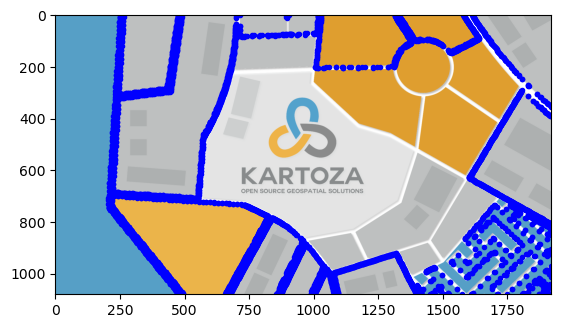

In [22]:
# Plot the initial contours
plt.imshow(cv2.cvtColor(map_img_resized, cv2.COLOR_BGR2RGB))
for contour in contours:
    for point in contour:
        plt.plot(point[0][0], point[0][1], 'b.')
initial_contours_image = os.path.join(current_dir, 'initial_contours.png')
plt.savefig(initial_contours_image)
plt.show()

In [23]:
# Find the starting contour closest to (250, 0)
def find_closest_point(contours, target_point):
    min_distance = float('inf')
    closest_point = None
    for contour in contours:
        for point in contour:
            distance = np.linalg.norm(np.array(point[0]) - np.array(target_point))
            if distance < min_distance:
                min_distance = distance
                closest_point = point[0]
    return closest_point

start_point = (250, 0)
end_point = (1920, 800)

starting_point = find_closest_point(contours, start_point)
ending_point = find_closest_point(contours, end_point)

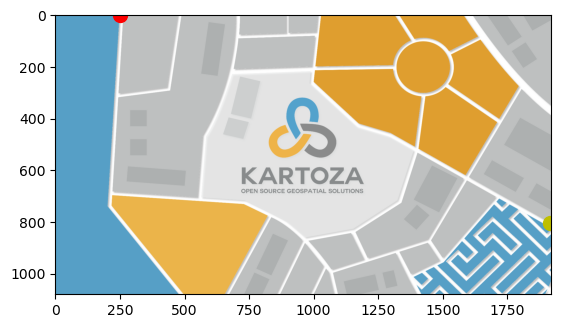

In [24]:
# Visualize the starting and ending points
plt.imshow(cv2.cvtColor(map_img_resized, cv2.COLOR_BGR2RGB))
plt.plot(starting_point[0], starting_point[1], 'ro', markersize=10)
plt.plot(ending_point[0], ending_point[1], 'yo', markersize=10)
extreme_contours_image = os.path.join(current_dir, 'extreme_contours.png')
plt.savefig(extreme_contours_image)
plt.show()

In [25]:
# Break contours into segments of maximum length 20 pixels
def break_into_segments(contours, max_length=20):
    new_contours = []
    for contour in contours:
        new_contour = []
        for i in range(len(contour) - 1):
            start_point = contour[i][0]
            end_point = contour[i + 1][0]
            distance = np.linalg.norm(np.array(start_point) - np.array(end_point))
            new_contour.append(start_point)
            if distance > max_length:
                num_segments = int(np.ceil(distance / max_length))
                for j in range(1, num_segments):
                    intermediate_point = start_point + (end_point - start_point) * (j / num_segments)
                    new_contour.append(intermediate_point)
        new_contour.append(contour[-1][0])
        new_contours.append(np.array(new_contour))
    return new_contours

segmented_contours = break_into_segments(contours)

In [26]:
# Construct the graph
def construct_graph(contours, tolerance=30):
    graph = {}
    for contour in contours:
        for point in contour:
            point_tuple = tuple(point)
            if point_tuple not in graph:
                graph[point_tuple] = []
            for other_contour in contours:
                for other_point in other_contour:
                    other_point_tuple = tuple(other_point)
                    if point_tuple != other_point_tuple and np.linalg.norm(np.array(point) - np.array(other_point)) < tolerance:
                        graph[point_tuple].append(other_point_tuple)
    return graph

graph = construct_graph(segmented_contours)

In [27]:
# Dijkstra's algorithm to find the shortest path
def dijkstra(graph, start, end):
    queue = [(0, start)]
    distances = {start: 0}
    previous_nodes = {start: None}

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        if current_node == end:
            break

        for neighbor in graph.get(current_node, []):
            distance = current_distance + np.linalg.norm(np.array(current_node) - np.array(neighbor))
            if distance < distances.get(neighbor, float('inf')):
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(queue, (distance, neighbor))

    path = []
    current_node = end
    while current_node is not None:
        path.append(current_node)
        current_node = previous_nodes[current_node]
    path.reverse()
    return path

path = dijkstra(graph, tuple(starting_point), tuple(ending_point))

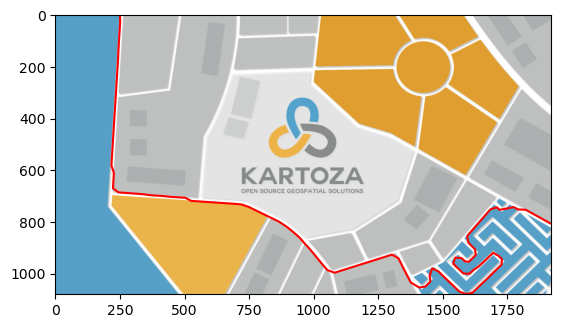

In [28]:
# Visualize the selected path
plt.imshow(cv2.cvtColor(map_img_resized, cv2.COLOR_BGR2RGB))
plt.plot([point[0] for point in path], [point[1] for point in path], 'r-')
selected_path_image = os.path.join(current_dir, 'selected_path.png')
plt.savefig(selected_path_image)
plt.show()

# Step 3: Initialize Pygame and create animation frames
pygame.init()

# Load the images
car_img = pygame.image.load(car_png_path)
map_img_resized = pygame.transform.scale(pygame.image.load(map_path), (1920, 1080))

# Set up the display
map_width, map_height = 1920, 1080
screen = pygame.display.set_mode((map_width, map_height))
pygame.display.set_caption('Car Animation')

# Variables for car movement
car_index = 0
car_pos = list(path[car_index])
car_rect = car_img.get_rect(center=car_pos)
speed = 10

# Use a temporary directory for storing intermediate frames
temp_dir = os.path.join(current_dir, 'temp_frames')
os.makedirs(temp_dir, exist_ok=True)

# Generate frames and save to disk to manage memory
frame_count = 0
while car_index < len(path) - 1:
    # Move the car
    next_pos = path[car_index + 1]
    dx, dy = next_pos[0] - car_pos[0], next_pos[1] - car_pos[1]
    dist = (dx**2 + dy**2)**0.5
    if dist < speed:
        car_pos = list(next_pos)
        car_index += 1
    else:
        car_pos[0] += speed * dx / dist
        car_pos[1] += speed * dy / dist

    # Update car rectangle
    car_rect = car_img.get_rect(center=car_pos)

    # Draw everything
    screen.blit(map_img_resized, (0, 0))
    screen.blit(car_img, car_rect.topleft)
    pygame.display.flip()

    # Save the frame
    frame = pygame.surfarray.array3d(screen)
    frame = np.transpose(frame, (1, 0, 2))  # Correct the orientation
    frame_image = Image.fromarray(frame)
    frame_path = os.path.join(temp_dir, f'frame_{frame_count:05d}.png')
    frame_image.save(frame_path)
    frame_count += 1

    # Control the frame rate
    pygame.time.Clock().tick(60)

pygame.quit()

In [29]:
# Step 4: Load frames from disk and save as a gif
frames = []
for i in range(frame_count):
    frame_path = os.path.join(temp_dir, f'frame_{i:05d}.png')
    frames.append(Image.open(frame_path))

gif_path = os.path.join(current_dir, 'car_animation_1920x1080.gif')
frames[0].save(gif_path, save_all=True, append_images=frames[1:], loop=0, duration=100)

In [30]:
# Cleanup temporary frames
for i in range(frame_count):
    frame_path = os.path.join(temp_dir, f'frame_{i:05d}.png')
    os.remove(frame_path)
os.rmdir(temp_dir)

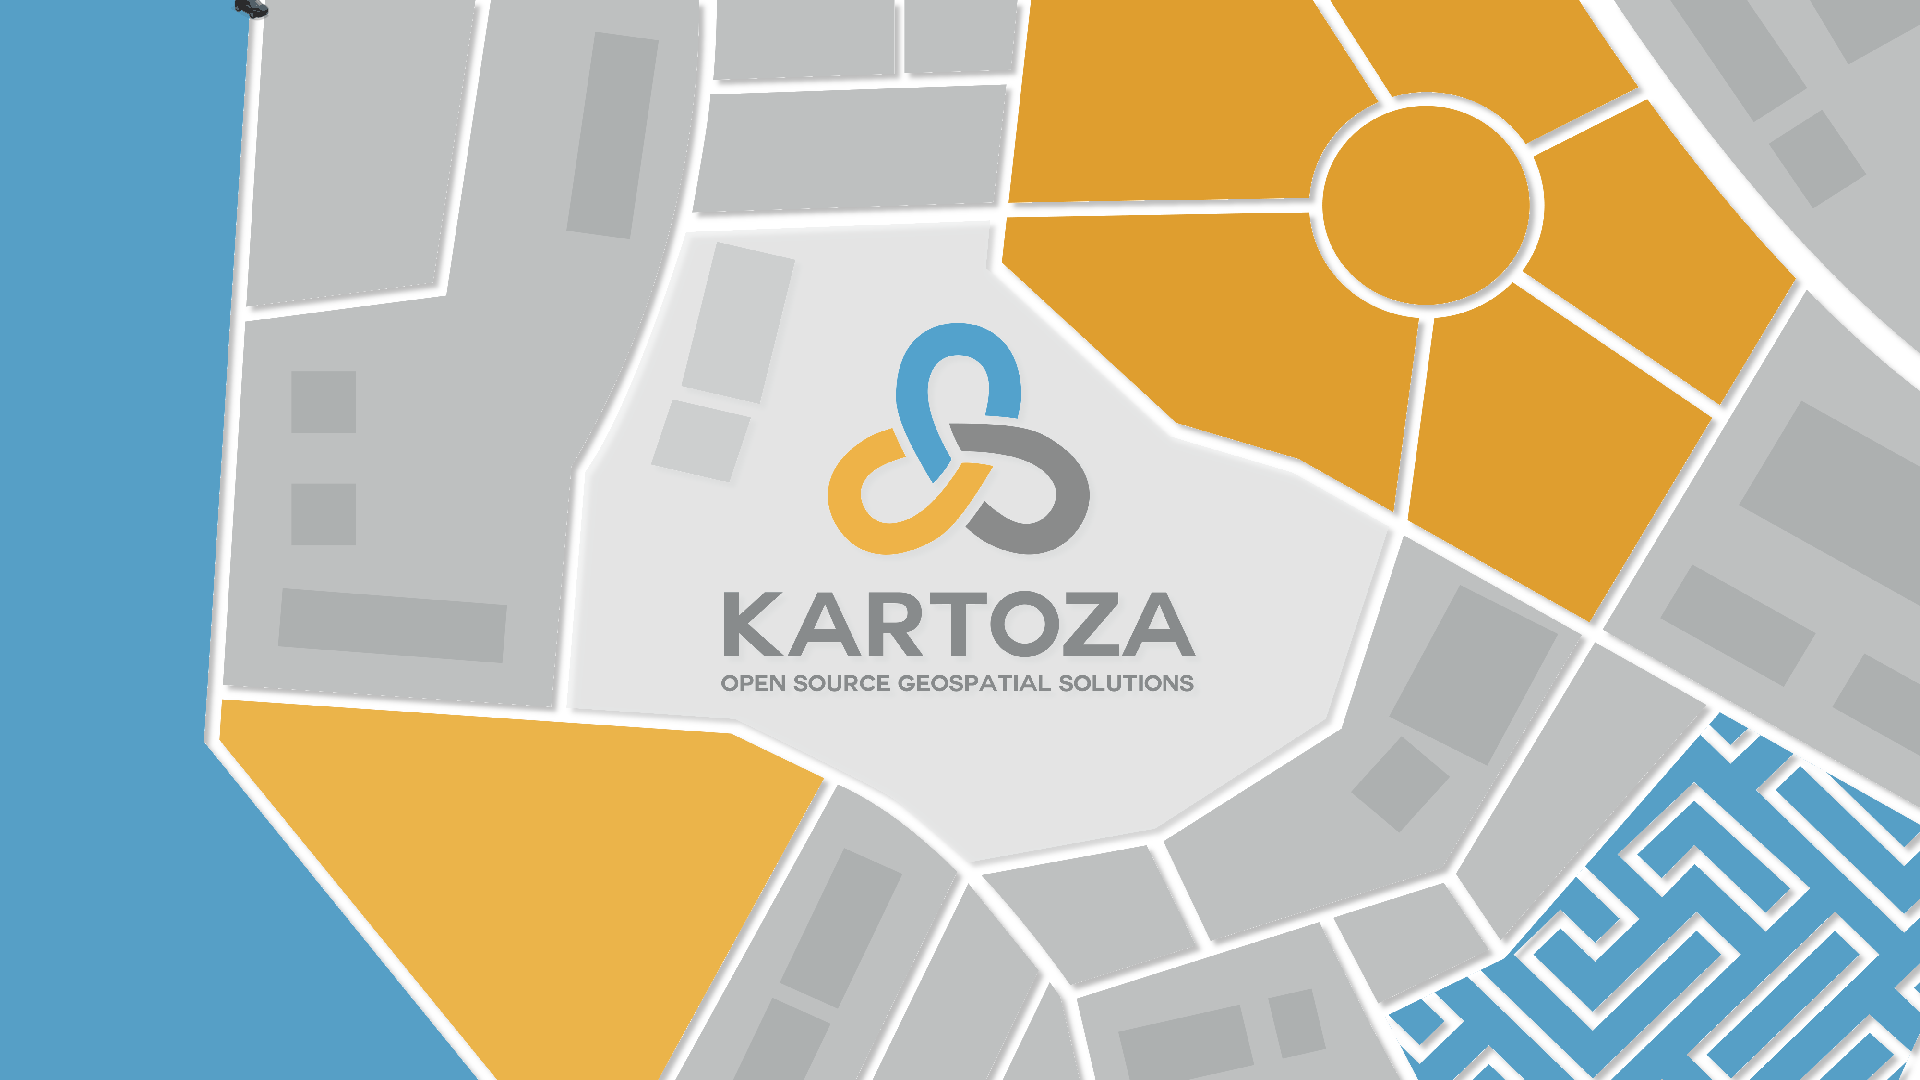

In [31]:
# Display the created GIF
from IPython.display import Image as IPImage
IPImage(filename=gif_path)